In [14]:
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

# 4. Fitting a distribution with Fitter

Fitter is a python library that utilizes the Scipy library's distribution to graph and calculate metrics for goodness of fit

In [10]:
df = pd.read_csv('data/sample_claims.csv')

In [19]:
f = Fitter(df)
f.fit()

c:\Users\jtsw1\anaconda\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
c:\Users\jtsw1\anaconda\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
c:\Users\jtsw1\anaconda\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not conver

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
powerlognorm,1.293603e-08,2773.575210,-2163.592005,inf,0.049866,0.961152
exponweib,1.320917e-08,2766.823685,-2161.586045,inf,0.050528,0.956632
genpareto,1.324450e-08,2771.265235,-2165.893991,inf,0.048613,0.968860
lomax,1.335057e-08,2770.057105,-2165.128198,inf,0.047501,0.974805
johnsonsb,1.359336e-08,2766.057875,-2158.833761,inf,0.048376,0.970194


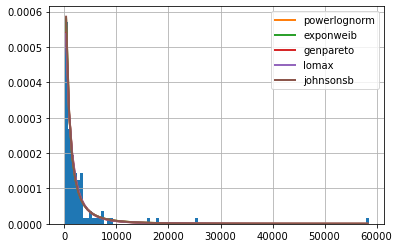

In [20]:
f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,4.095029e-08,3212.394003,-2052.967090,inf,0.117833,0.128244
expon,8.627424e-08,3575.446841,-1990.559271,inf,0.184990,0.002388


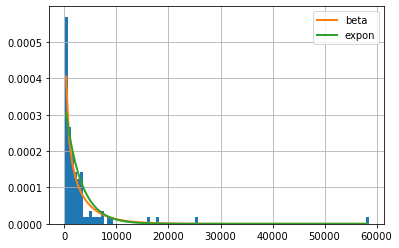

In [17]:
f = Fitter(df, distributions=["expon", "beta"])
f.fit()
f.summary()

In [4]:
x = np.linspace(df.min(),df.max(),df.shape[0])

### Evaluating the goodness of fit

In [28]:
log_likelihood = np.sum(np.log(st.norm.pdf(df, loc, scale)))

In [31]:
-2*log_likelihood + 2*2

1971.346878750647